<a href="https://colab.research.google.com/github/palash04/Artificial-Intelligence/blob/master/Neural_Networks/Conv_NN/_03_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training a CNN to classify images from CIFAR-10 database

https://www.kaggle.com/c/cifar-10

In [8]:
# Testing for cuda
# Since, the images will be of size (32x32x3), so it will be useful to speed up the training time by using GPU

import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print ('CUDA is not available. Training on CPU')
else:
  print ('CUDA is available. Training on GPU')

CUDA is available. Training on GPU


In [9]:
print (torch.cuda.get_device_name(0))

Tesla T4


# Loading the data
Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [10]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [11]:
# num of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# choose the training and test datasets
train_data = datasets.CIFAR10('data',train=True,download=True,transform=transform)
test_data = datasets.CIFAR10('data',train=False,download=True,transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx,valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and samplers)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=valid_sampler,num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)

# specify the image classes 
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


# Visualize a batch of training data

In [12]:
import matplotlib.pyplot as plt

# helper function to un-normalize and display an image
def imshow(img):
  img = img/2 + 0.5
  plt.imshow(np.transpose(img,(1,2,0)))   # convert from tensor image

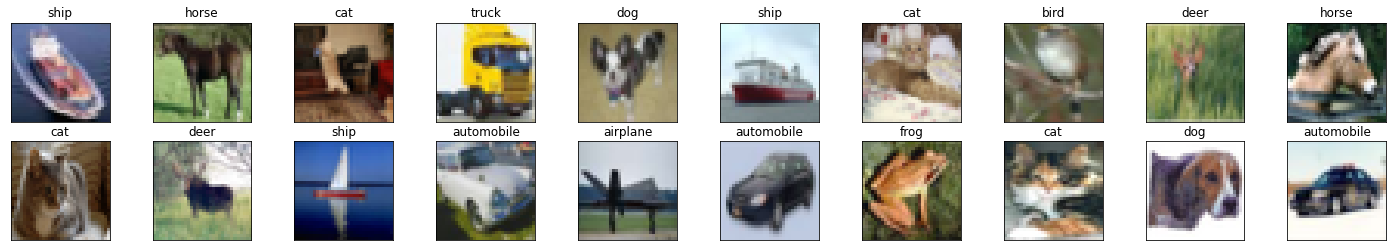

In [13]:
# obtain one batch of training images
dataiter = iter(train_loader)
images,labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in batch along with the corresponding labels
fig = plt.figure(figsize=(25,4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

## View an image in more detail

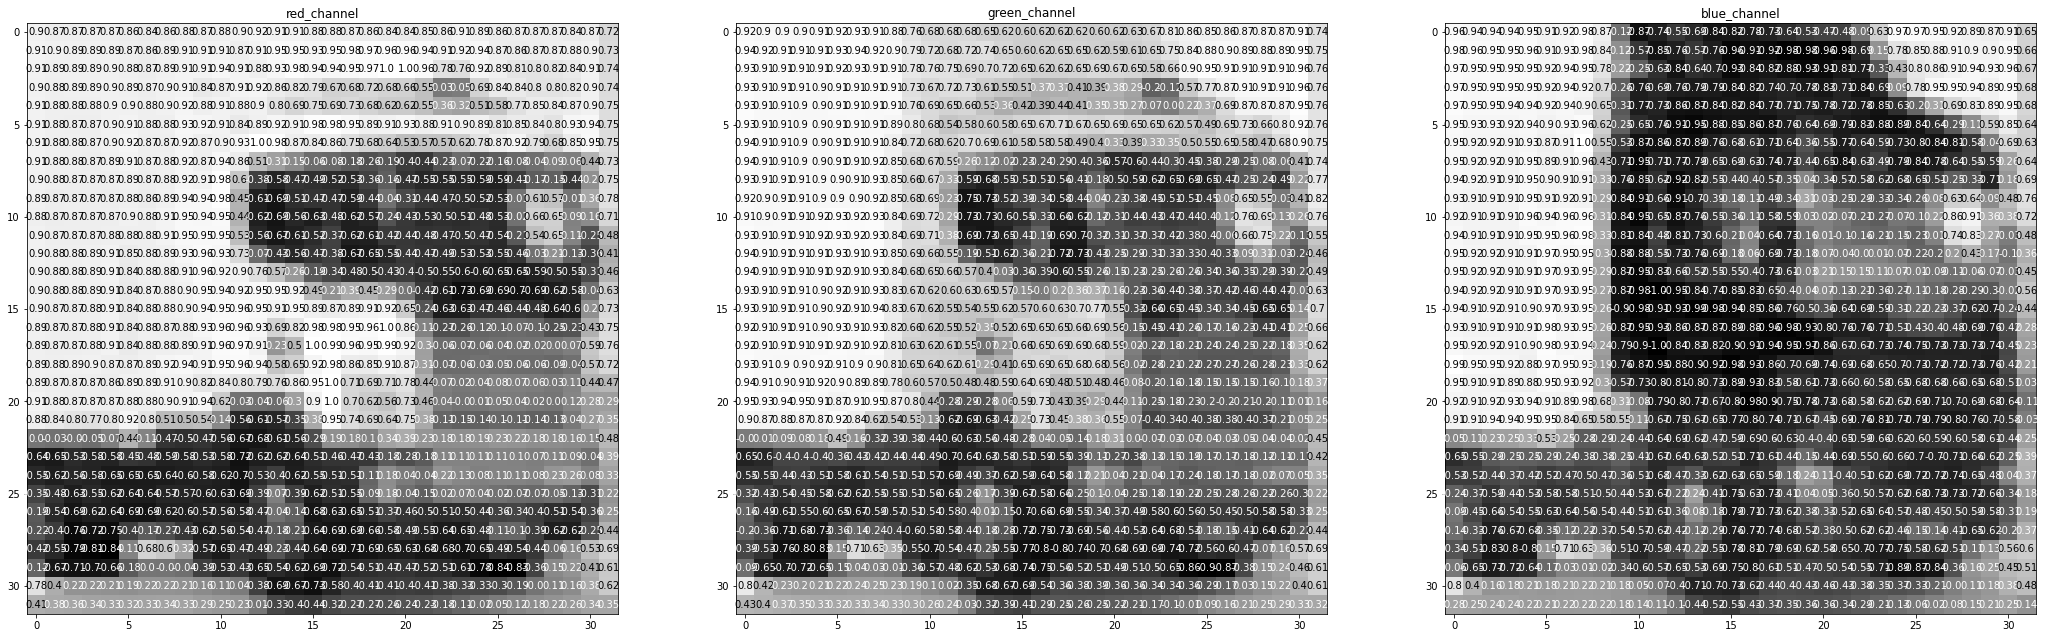

In [14]:
rgb_img = np.squeeze(images[3])
channels = ['red_channel','green_channel','blue_channel']

fig = plt.figure(figsize=(36,36))
for idx in np.arange(rgb_img.shape[0]):
  ax = fig.add_subplot(1,3,idx+1)
  img = rgb_img[idx]
  ax.imshow(img,cmap='gray')  
  ax.set_title(channels[idx])
  width,height = img.shape
  thresh = img.max()/2.5
  for x in range(width):
    for y in range(height):
      val = round(img[x][y],2) if img[x][y] != 0 else 0
      ax.annotate(str(val),xy=(y,x),
                  horizontalalignment = 'center',
                  verticalalignment = 'center',
                  color = 'white' if img[x][y] < thresh else 'black')

# Define the Network Architecture

### Defining a CNN Architecture

- Convolutional Layers, which can be thought of as stack of filtered images
- Maxpooling Layers, which reduce the size of x-y size of an input, keeping only the most active pixels from the previous layer
- The usual linear + dropout layers to avoid overfitting and produce a 10-dim output.

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
# define CNN architrcture
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    # convolutional layer (sees 32x32x3 image tensor)
    self.conv1 = nn.Conv2d(3,16,3,padding=1)
    # convolutional layer (sees 16x16x16 image tensor)
    self.conv2 = nn.Conv2d(16,32,3,padding=1)
    # convolutional layer (sees 8x8x32 image tensor)
    self.conv3 = nn.Conv2d(32,64,3,padding=1)
    # max pooling layer
    self.pool = nn.MaxPool2d(2,2)
    # linear layer (64 x 4 x 4 , 500)
    self.fc1 = nn.Linear(64*4*4, 500)
    # linear layer (500, 10)
    self.fc2 = nn.Linear(500,10)
    # dropout layer (p=0.25)
    self.dropout = nn.Dropout(0.25)

  def forward(self,x):
    # add sequence of convolutional and max pooling layer
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    # flatten image input
    x = x.view(-1, 64*4*4)
    # add dropout layer
    x = self.dropout(x)
    # add 1st hidden layer, with relu activation function
    x = F.relu(self.fc1(x))
    # add dropout layer
    x = self.dropout(x)
    # add 2nd hidden layer, without relu activation function
    x = self.fc2(x)
    return x

# create a complete CNN model
model = Net()
print (model)

# move tensors to gpu if cuda is available
if train_on_gpu:
  model.cuda()


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


## Specify loss function and optimizer


In [17]:
import torch.optim as optim

# specify loss function (categorical cross entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)


## Train the Network
Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [18]:
# number of epochs
epochs = 30
valid_loss_min = np.inf     # track change in validation loss
for epoch in range(1, epochs+1):
  # keep track of training and validation loss
  train_loss = 0.0
  valid_loss = 0.0

  #################
  #train the model#
  #################

  model.train()
  for data,target in train_loader:
    # move tensors to gpu if cuda is available
    if train_on_gpu:
      data,target = data.cuda(),target.cuda()
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output,target)
    # backward pass: compute gradient of the loss with respec to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()
    # update training loss
    train_loss += loss.item()*data.size(0)

  
  ####################
  #validate the model#
  ####################

  model.eval()
  for data,target in valid_loader:
    # move tensors to gpu if cuda is available
    if train_on_gpu:
      data,target = data.cuda(),target.cuda()
    
    # forward pass
    output = model(data)
    # calculate loss
    loss = criterion(output,target)
    # update average validation loss
    valid_loss += loss.item()*data.size(0)

  # calculate the average losses
  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)

  # print training/validation statistics
  print ('Epoch: {}/{} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'.format(epoch,epochs,train_loss,valid_loss))

  # save model if validation loss has decreased 
  if valid_loss <= valid_loss_min:
    print ('Validation Loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(valid_loss_min, valid_loss))
    torch.save(model.state_dict(),'model_cifar.pt')
    valid_loss_min = valid_loss

Epoch: 1/30 	 Training Loss: 2.122105 	 Validation Loss: 1.859316
Validation Loss decreased (inf --> 1.859316). Saving model...
Epoch: 2/30 	 Training Loss: 1.698125 	 Validation Loss: 1.513436
Validation Loss decreased (1.859316 --> 1.513436). Saving model...
Epoch: 3/30 	 Training Loss: 1.489924 	 Validation Loss: 1.396749
Validation Loss decreased (1.513436 --> 1.396749). Saving model...
Epoch: 4/30 	 Training Loss: 1.383935 	 Validation Loss: 1.277904
Validation Loss decreased (1.396749 --> 1.277904). Saving model...
Epoch: 5/30 	 Training Loss: 1.287507 	 Validation Loss: 1.189007
Validation Loss decreased (1.277904 --> 1.189007). Saving model...
Epoch: 6/30 	 Training Loss: 1.201983 	 Validation Loss: 1.133256
Validation Loss decreased (1.189007 --> 1.133256). Saving model...
Epoch: 7/30 	 Training Loss: 1.129263 	 Validation Loss: 1.046321
Validation Loss decreased (1.133256 --> 1.046321). Saving model...
Epoch: 8/30 	 Training Loss: 1.061591 	 Validation Loss: 1.012475
Validati

## Load the model with lowest validation loss

In [19]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

## Test the trained network

In [20]:
# track the test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over the test data
for data,target in test_loader:
  if train_on_gpu:
    data,target = data.cuda(),target.cuda()
  
  # forward pass
  output = model(data)
  # calculate the loss
  loss = criterion(output,target)
  # update test loss
  test_loss += loss.item()*data.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  # compare predictions to true label
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  # calculate test accuracy for each object class
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
        classes[i], 100 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.746092

Test Accuracy of airplane: 77% (773/1000)
Test Accuracy of automobile: 88% (889/1000)
Test Accuracy of  bird: 63% (637/1000)
Test Accuracy of   cat: 51% (510/1000)
Test Accuracy of  deer: 73% (738/1000)
Test Accuracy of   dog: 67% (675/1000)
Test Accuracy of  frog: 78% (780/1000)
Test Accuracy of horse: 80% (806/1000)
Test Accuracy of  ship: 85% (859/1000)
Test Accuracy of truck: 82% (829/1000)

Test Accuracy (Overall): 74% (7496/10000)


## Visualize the sample test results

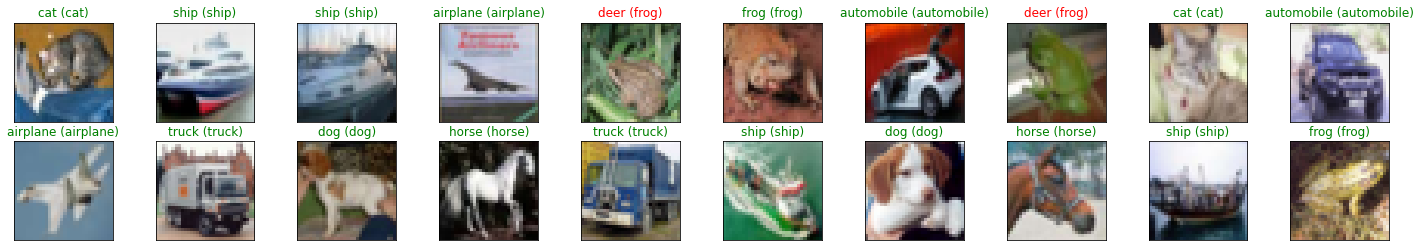

In [21]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

### Augmentation
We can use augmentation to improve the accuracy. We perform some simple data augmentation by randomly flipping and rotating the given image data.

This type of data augmentation should add some positional variety to these images, so that when we train a model on this data, it will be robust in the face of geometric changes (i.e. it will recognize a ship, no matter which direction it is facing).

In [ ]:
# To achieve augmentation we do - 
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])